In [409]:
import pandas as pd
import numpy as np
from sklearn.dummy import DummyClassifier
from datetime import date
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import pickle
from sklearn.metrics import confusion_matrix, hamming_loss, plot_confusion_matrix
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
import xgboost as xgb

import geopandas as gpd
from shapely.geometry import Point, Polygon
import descartes

# Business Question
In Tanzania, 50% of the population does not have access to clean drinking water. Ground is generally cleaner than surface water which is often polluted by sewers and toxic waste from factories. Sometimes, people have to walk miles to the nearest water pump. With limited resources it is imperative to identify where best to allocate resources for pump repair.

# Clean Data

In [208]:
def read_csv():
    
    ''' This function imports necessary data'''
    
    df_submission = pd.read_csv('../../../src/data/data/raw/SubmissionFormat.csv')
    df_test = pd.read_csv('../../../src/data/data/raw/test_set.csv')
    df_training_labels = pd.read_csv('../../../src/data/data/raw/train_set_labels.csv')
    df_training_values = pd.read_csv('../../../src/data/data/raw/train_set_values.csv')
    return (df_submission, df_test, df_training_labels, df_training_values)

In [209]:
def drop(df_training_values, df_training_labels):
    ''' drops uneccesary data'''
   
    X_train = df_training_values.drop('id',axis=1)
    y_train = df_training_labels.drop('id',axis=1)
    X_test = df_test.drop('id',axis=1)
    return X_train, y_train, X_test

In [210]:
def mod_date(X):
    ''' fixes date column to make it a continuous variable'''
    
    X['date_recorded'] = pd.to_datetime(X['date_recorded'])
    X['days_old'] = pd.to_datetime(date.today()) - X['date_recorded']
    X = X.drop('date_recorded',axis=1)
    return X

In [211]:
def continuous_fix(X):
    """
    This function's main purpose is to address the '0' values in construction_year. 0 is am impossible value for 
    year of construction, so it casts '0' as 'unknown'. Because 'unknown' is not a continuous value, this function
    then bins the years into decades. So, the resulting column is categorical data with decade values. 
    """
    def year(row):
        if row['construction_year'] >= 1960 and row['construction_year'] < 1970:
            return '60'
        elif row['construction_year'] >= 1970 and row['construction_year'] < 1980:
            return '70'
        elif row['construction_year'] >= 1980 and row['construction_year'] < 1990:
            return '80'
        elif row['construction_year'] >= 1990 and row['construction_year'] < 2000:
            return '90'
        elif row['construction_year'] >= 2000 and row['construction_year'] < 2010:
            return '00'
        elif row['construction_year'] >= 2010:
            return '10'
        else:
            return 'unknown'
        
    X['construction_year'] = X.apply(lambda row: year(row), axis=1)
    X['gps_height'].loc[X['gps_height']<0]=0
    
    return X

In [215]:
def nan_func(X):
    '''gets rid of nan functions'''
    column = ['installer', 'scheme_management', 'permit', 'waterpoint_type_group', 'source_class']
    for col in column:
        X[col].fillna('others', inplace=True)
    return X, 

In [217]:
def permit(X):
    ''' fixes permit column'''
    X['permit'] = X['permit'].replace({True: 'T', False: 'F'})
    return X

In [221]:
def choose_var(X):
    ''' chooses which variable to use'''
    
    X = X[['amount_tsh','gps_height', 'installer','wpt_name', 'num_private','basin','population','scheme_management', 'region',
                            'permit', 'construction_year','extraction_type','management_group','payment','quality_group','source_class','waterpoint_type_group','days_old']]
    return X

In [224]:
def clean_object(input_df):
    ''' makes dataset smaller to account for computational cost'''
    column = input_df.columns
    for col in column:
        if (input_df[col].dtype) == object:
            to_change = []
            if input_df[col].value_counts().size > 50:
                for ind, val in enumerate(input_df[col].value_counts()):
                    if (val < 500):
                        to_change.append(input_df[col].value_counts().keys()[ind])
            for chan in to_change:
                input_df[col].replace(chan, 'other', inplace = True)
    return input_df

In [239]:
#parses df for cateborical variables
# def ohe_func(input_df: pd.DataFrame, cat_var: List[str]) -> pd.DataFrame:
def ohe_func(input_df, X_test):
    """One Hot Encodes categorical variables"""
    object_list = []
    other_list = []
    items = ['amount_tsh', 'gps_height', 'installer', 'wpt_name', 'num_private','region',
       'basin', 'population', 'scheme_management', 'permit','construction_year', 'extraction_type',
        'management_group', 'payment', 'quality_group', 'source_class', 'waterpoint_type_group']
    for var in items:
        if (input_df[var].dtype) == object:
            object_list.append(var)
        else:
            other_list.append(var)
#         # Load necessary data
    cat_df = input_df[object_list]
    cat_df_test = X_test[object_list]
#         # Create OHE object
    ohe = OneHotEncoder(categories = 'auto', handle_unknown='ignore').fit(cat_df)
#         # Create OHE DataFrame
    ohe_df = pd.DataFrame(ohe.transform(cat_df).toarray(), 
                    columns=ohe.get_feature_names(object_list))
    ohe_df_test = pd.DataFrame(ohe.transform(cat_df_test).toarray(), 
                    columns=ohe.get_feature_names(object_list))
    return pd.concat([ohe_df,input_df[other_list]], axis=1), pd.concat([ohe_df_test,X_test[other_list]], axis=1)
    


In [219]:
def dummy():
    ''' creates a dummy baseline model'''
    clf = DummyClassifier(strategy='most_frequent', random_state=0)
    clf.fit(X_train, y_train)
    return clf.score(X_train, y_train)

In [240]:
X_train_min_ohe, X_test_min_ohe = ohe_func(X_clean_train_min, X_clean_test_min)

## Writing Objects to Pickle

In [244]:
with open('data\X_train_min_ohe.pickle', 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(X_train_min_ohe, f, pickle.HIGHEST_PROTOCOL)

In [245]:
with open('data\X_test_min_ohe.pickle', 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(X_test_min_ohe, f, pickle.HIGHEST_PROTOCOL)

## Importing Objects from Pickle Files

In [1]:
with open('data\X_train_min_ohe.pickle', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    X_train_min_ohe = pickle.load(f)


NameError: name 'pickle' is not defined

In [2]:
with open('data\X_test_min_ohe.pickle', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    X_test_min_ohe = pickle.load(f)


NameError: name 'pickle' is not defined

In [182]:
def get_score(model, X_train, y_train, y_train_hat):  
    ''' This method gets the evaluation scores used for each metric'''
    rec = recall_score(y_train, y_train_hat, average = 'weighted')
    hamming = hamming_loss(y_train, y_train_hat)
    f1 = f1_score(y_train, y_train_hat, average = 'weighted')
    prec = precision_score(y_train, y_train_hat, average = 'weighted')
    acc = model.score(X_train, y_train)
    print(f"""
        Recall Score: {rec} 
        Hamming Loss: {hamming} 
        f1 Score: {f1} 
        Precision Score: {prec}
        Accuracy: {acc}""")

# Models
For each model the data has been run on it and best parameters have been found. Different evaluation scores are listed for each evaluation. We concluded that cross-validation was the best metric to use for determining model performance

# Decision Tree Classifier

In [394]:
dtc = DecisionTreeClassifier()
dtc.fit(X_train_min_ohe, y_train)
y_train_pred_dtc = dtc.predict(X_train_min_ohe)
get_score(dtc, X_train_min_ohe, y_train, y_train_pred_dtc)

In [398]:
cf_dtc = confusion_matrix(y_train, y_train_pred_dtc)
cf_dtc

array([[31011,   239,  1009],
       [  910,  3169,   238],
       [ 2355,   212, 20257]])

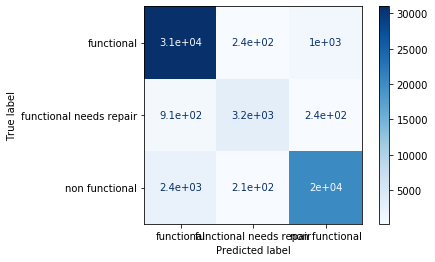

In [399]:
plot_confusion_matrix(dtc, X_train_min_ohe, y_train, cmap=plt.cm.
                     Blues)

In [400]:
dt_param_grid = {
    'criterion': ['gini'],
    'max_depth': [139],
    'min_samples_split': [9],
    'min_samples_leaf': [9]
}

In [401]:
# Instantiate GridSearchCV
dt_grid_search = GridSearchCV(dtc, dt_param_grid, cv=3, return_train_score=True)

# Fit to the data
dt_grid_search.fit(X_train_min_ohe, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'criterion': ['gini'], 'max_depth': [139],
          

In [402]:
dt_grid_search.best_params_

{'criterion': 'gini',
 'max_depth': 139,
 'min_samples_leaf': 9,
 'min_samples_split': 9}

In [404]:
dt_cv_score = cross_val_score(dtc, X_train_min_ohe, y_train, cv=7)
mean_dt_cv_score = np.mean(dt_cv_score)

print(f"Mean Cross Validation Score: {mean_dt_cv_score :.2%}")

Mean Cross Validation Score: 71.14%
Mean Cross Validation Best Param Score: 72.52%


In [ ]:
def feature_importance(X_train_min_ohe, y_train):
    dtc2 = DecisionTreeClassifier(criterion='gini',
     max_depth= 139,
     min_samples_leaf= 9,
     min_samples_split= 9)
    dtc2.fit(X_train_min_ohe, y_train)
    y_train_pred_dtc = dtc2.predict(X_train_min_ohe)
    get_score(dtc2, X_train_min_ohe, y_train, y_train_pred_dtc)
    
    dt2_cv_score = cross_val_score(dtc2, X_train_min_ohe, y_train, cv=7)
    mean_dt2_cv_score = np.mean(dt2_cv_score)
    
    print(f"Mean Cross Validation Best Param Score: {mean_dt2_cv_score :.2%}")
    
    dtc2.feature_importances_
    X_columns = pd.DataFrame(X_train_min_ohe.columns)
    features = pd.DataFrame(dtc2.feature_importances_)
    X_features = pd.concat([X_columns, features], axis= 1)
    X_features.columns = ['features','values']
    
    return X_features.nlargest(50, 'values')


# Bagging

In [15]:
bagged_tree =  BaggingClassifier()
bagged_tree.fit(X_train_min_ohe, y_train)
y_train_pred_bagged = bagged_tree.predict(X_train_min_ohe)
get_score(bagged_tree, X_train_min_ohe, y_train, y_train_pred_bagged)

In [27]:
cf_bt = confusion_matrix(y_train, y_train_pred_bagged)
cf_bt

array([[30572,   349,  1338],
       [ 1006,  3002,   309],
       [ 2582,   228, 20014]])

In [28]:
bt_param_grid = {
    'n_estimators' : [200],
    'max_samples' : [.4],
    'max_features': [.6]
}

In [29]:
# Instantiate GridSearchCV
bt_grid_search = GridSearchCV(bagged_tree, bt_param_grid, cv=3, return_train_score=True)

# Fit to the data
bt_grid_search.fit(X_train_min_ohe, y_train)

/Users/flatironschool/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/flatironschool/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/flatironschool/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/flatironschool/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/ensembl

GridSearchCV(cv=3, error_score=nan,
             estimator=BaggingClassifier(base_estimator=None, bootstrap=True,
                                         bootstrap_features=False,
                                         max_features=1.0, max_samples=1.0,
                                         n_estimators=10, n_jobs=None,
                                         oob_score=False, random_state=None,
                                         verbose=0, warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'max_features': [0.6], 'max_samples': [0.4],
                         'n_estimators': [200]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring=None, verbose=0)

In [30]:
bt_grid_search.best_params_

{'max_features': 0.6, 'max_samples': 0.4, 'n_estimators': 200}

In [271]:
bt2 = BaggingClassifier(max_features=0.6,
 max_samples= 0.4,
 n_estimators= 200)
bt2.fit(X_train_min_ohe, y_train)
y_train_pred_bt2 = bt2.predict(X_train_min_ohe)
get_score(bt2, X_train_min_ohe, y_train, y_train_pred_bt2)

/Users/flatironschool/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



        Recall Score: 0.8551178451178452 
        Hamming Loss: 0.1448821548821549 
        f1 Score: 0.8483527653873113 
        Precision Score: 0.8585399285864908
        Accuracy: 0.8551178451178452


In [272]:
bt_cv_score = cross_val_score(bagged_tree, X_train_min_ohe, y_train, cv=7)
mean_bt_cv_score = np.mean(bt_cv_score)

bt2_cv_score = cross_val_score(bt2, X_train_min_ohe, y_train, cv=7)
mean_bt2_cv_score = np.mean(bt2_cv_score)

print(f"Mean Cross Validation Score: {mean_bt_cv_score :.2%}")
print(f"Mean Cross Validation Best Param Score: {mean_bt2_cv_score :.2%}")

/Users/flatironschool/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/flatironschool/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/flatironschool/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/flatironschool/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/ensembl

KeyboardInterrupt: 

In [273]:
def bagging_model(X_train_min_ohe, y_train):
    bt2 = BaggingClassifier(max_features=0.6,
    max_samples= 0.4,
    n_estimators= 200)
    bt2.fit(X_train_min_ohe, y_train)
    y_train_pred_bt2 = bt2.predict(X_train_min_ohe)
    get_score(bt2, X_train_min_ohe, y_train, y_train_pred_bt2)

    bt2_cv_score = cross_val_score(bt2, X_train_min_ohe, y_train, cv=7)
    mean_bt2_cv_score = np.mean(bt2_cv_score)

    print(f"Mean Cross Validation Best Param Score: {mean_bt2_cv_score :.2%}")
    
    return bt2

In [274]:
bt2 = bagging_model(X_train_min_ohe, y_train)

/Users/flatironschool/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



        Recall Score: 0.8541077441077441 
        Hamming Loss: 0.14589225589225588 
        f1 Score: 0.8475048872317832 
        Precision Score: 0.8572438487270709
        Accuracy: 0.8541077441077441


/Users/flatironschool/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/flatironschool/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/flatironschool/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/flatironschool/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/ensembl

Mean Cross Validation Best Param Score: 75.74%


# Random Forest

In [427]:
rf = RandomForestClassifier()
rf.fit(X_train_min_ohe, y_train)
y_train_pred_rf = rf.predict(X_train_min_ohe)

/Users/flatironschool/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


KeyboardInterrupt: 

In [153]:
get_score(rf, X_train_min_ohe, y_train, y_train_pred_rf)


        Recall Score: 0.916043771043771 
        Hamming Score: 0.08395622895622895 
        f1 Score: 0.9151533943522847 
        Precision Score: 0.9158436874146281
        Accuracy: 0.916043771043771


In [154]:
cf_rf = confusion_matrix(y_train, y_train_pred_rf)
cf_rf

array([[30755,   291,  1213],
       [  862,  3166,   289],
       [ 2140,   192, 20492]])

In [173]:
rf_param_grid = {
    'n_estimators': [700, 1100],
    'criterion': ['entropy'],
    'max_depth': [40],
    'min_samples_split': [5],
    'min_samples_leaf': [2]
}

In [174]:
# Instantiate GridSearchCV
rf_grid_search = GridSearchCV(rf, rf_param_grid, cv=3, return_train_score=True)

# Fit to the data
rf_grid_search.fit(X_train_min_ohe, y_train)

/Users/flatironschool/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/flatironschool/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/flatironschool/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/flatironschool/

GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [175]:
rf_grid_search.best_params_

{'criterion': 'entropy',
 'max_depth': 40,
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'n_estimators': 1100}

In [176]:
rf2 = RandomForestClassifier(criterion='entropy',
 max_depth= 40,
 min_samples_split= 5,
 min_samples_leaf = 2,
 n_estimators = 600
                       )
rf2.fit(X_train_min_ohe, y_train)
y_train_pred_rf2 = rf2.predict(X_train_min_ohe)
get_score(rf2, X_train_min_ohe, y_train, y_train_pred_rf2)

/Users/flatironschool/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys



        Recall Score: 0.8117171717171717 
        Hamming Score: 0.18828282828282827 
        f1 Score: 0.7971303054323561 
        Precision Score: 0.8146129408966476
        Accuracy: 0.8117171717171717


In [177]:
rf_cv_score = cross_val_score(rf, X_train_min_ohe, y_train, cv=7)
mean_rf_cv_score = np.mean(rf_cv_score)

rf2_cv_score = cross_val_score(rf2, X_train_min_ohe, y_train, cv=7)
mean_rf2_cv_score = np.mean(rf2_cv_score)

print(f"Mean Cross Validation Score: {mean_rf_cv_score :.2%}")
print(f"Mean Cross Validation Best Param Score: {mean_rf2_cv_score :.2%}")

/Users/flatironschool/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/flatironschool/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/flatironschool/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/flatironschool/

Mean Cross Validation Score: 74.56%
Mean Cross Validation Best Param Score: 75.62%


# KNN

In [ ]:
ss = StandardScaler()
scaled_X_train = ss.fit_transform(X_train_min_ohe)
scaled_X_test = ss.transform(X_test_min_ohe)

In [429]:
knn = KNeighborsClassifier()
knn.fit(scaled_X_train, y_train)
y_train_pred_knn = knn.predict(scaled_X_train)

/Users/flatironschool/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


In [430]:
get_score(knn, scaled_X_train, y_train, y_train_pred_knn)


        Recall Score: 0.7804040404040404 
        Hamming Loss: 0.2195959595959596 
        f1 Score: 0.7728281874730226 
        Precision Score: 0.7761620245239425
        Accuracy: 0.7804040404040404


In [431]:
cf_knn = confusion_matrix(y_train, y_train_pred_rf)
cf_knn

array([[30819,   262,  1178],
       [  876,  3167,   274],
       [ 2189,   187, 20448]])

In [432]:
knn_param_grid = {
    'n_neighbors': [5, 3, 10],
    'p': [2, 3, 4],
    'weights':['uniform', 'distance']
} 

In [ ]:
# Instantiate GridSearchCV
knn_grid_search = GridSearchCV(knn, knn_param_grid, cv=3, return_train_score=True)

# Fit to the data
knn_grid_search.fit(scaled_X_train, y_train)

In [ ]:
knn_grid_search.best_params_

# XG Boost

In [180]:
xg = xgb.XGBClassifier()
xg.fit(X_train_min_ohe, y_train)
y_train_pred_xg = xg.predict(X_train_min_ohe)

/Users/flatironschool/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/flatironschool/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [181]:
get_score(xg, X_train_min_ohe, y_train, y_train_pred_xg)


        Recall Score: 0.7025084175084175 
        Hamming Score: 0.2974915824915825 
        f1 Score: 0.668545628497493 
        Precision Score: 0.6993062552633829
        Accuracy: 0.7025084175084175


In [182]:
cf_xg = confusion_matrix(y_train, y_train_pred_xg)
cf_xg

array([[29232,    24,  3003],
       [ 3400,    72,   845],
       [10352,    47, 12425]])

In [ ]:
xg_param_grid = {
    'learning_rate': [.1, .01, .5, 1],
    'max_depth': [3, 5, 8],
    'n_estimators': [10, 100, 1000],    
}

xg_param_grid = {
    'learning_rate': [.1],
    'max_depth': [40],
    'n_estimators': [600],    
}

In [ ]:
# Instantiate GridSearchCV
xg_grid_search = GridSearchCV(xg, xg_param_grid, cv=3, return_train_score=True)

# Fit to the data
xg_grid_search.fit(X_train_min_ohe, y_train)

In [195]:
def result(X_test_min_ohe, bt2):
    y_test_pred_bagged = bt2.predict(X_test_min_ohe)
    y_test_pred_bagged = pd.DataFrame(y_test_pred_bagged, columns = ['status_group'])
    final = pd.concat([X_test, y_test_pred_bagged], axis=1)
    final['status_group'].value_counts()/final['status_group'].count()
    return final

,amount_tsh,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,...,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,days_old,status_group
0,0.0,Dmdd,1996,DMDD,35.290799,-4.059696,Dinamu Secondary School,0,Internal,Magoma,...,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,other,other,2523 days,functional
1,0.0,Government Of Tanzania,1569,DWE,36.656709,-3.309214,Kimnyak,0,Pangani,Kimnyak,...,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe,2523 days,functional
2,0.0,others,1567,others,34.767863,-5.004344,Puma Secondary,0,Internal,Msatu,...,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,other,other,2526 days,functional
3,0.0,Finn Water,267,FINN WATER,38.058046,-9.418672,Kwa Mzee Pange,0,Ruvuma / Southern Coast,Kipindimbi,...,good,dry,dry,shallow well,shallow well,groundwater,other,other,2536 days,non functional
4,500.0,Bruder,1260,BRUDER,35.006123,-10.950412,Kwa Mzee Turuka,0,Ruvuma / Southern Coast,Losonga,...,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,2472 days,functional
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14845,0.0,Danida,34,Da,38.852669,-6.582841,Kwambwezi,0,Wami / Ruvu,Yombo,...,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe,3234 days,non functional
14846,1000.0,Hiap,0,HIAP,37.451633,-5.350428,Bonde La Mkondoa,0,Pangani,Mkondoa,...,salty,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump,3209 days,functional
14847,0.0,others,1476,others,34.739804,-4.585587,Bwawani,0,Internal,Juhudi,...,good,insufficient,insufficient,dam,dam,surface,communal standpipe,communal standpipe,2495 days,functional
14848,0.0,Germany,998,DWE,35.432732,-10.584159,Kwa John,0,Lake Nyasa,Namakinga B,...,good,insufficient,insufficient,river,river/lake,surface,communal standpipe,communal standpipe,2509 days,functional


In [419]:
def map_pumps(df_train):
    """
    This function maps the pumps, with their status, across Tanzania.
    You must install/import the following libraries:
        import geopandas as gpd
        from shapely.geometry import Point, Polygon
        import matplotlib.pyplot as plt
        import descartes
    """
    #import a Tanzania shape files
    tanz_base = gpd.read_file('../../../src/data/data/raw/geographic/tza_admbnda_adm0_20181019.shp')
    regions = gpd.read_file('../../../src/data/data/raw/geographic/tza_admbnda_adm1_20181019.shp')
    ward = gpd.read_file('../../../src/data/data/raw/geographic/tza_admbnda_adm2_20181019.shp')
    county = gpd.read_file('../../../src/data/data/raw/geographic/tza_admbnda_adm3_20181019.shp')
    #set the WGS84 projection
    crs = {'init':'espg:4326'}
    #create geometric points for projecting
    geometry = [Point(xy) for xy in zip( df_train['longitude'], df_train['latitude'])]
    geo_df_train = gpd.GeoDataFrame(df_train, crs = crs, geometry = geometry)
    df_train = df_train.drop('geometry', axis=1)
    #remove geographic outliers/NaNs (there were ~1800 points with longitude = 0 (Earlier test-mapping showed this))
    geo_df_train = geo_df_train[geo_df_train.longitude != 0]
    #plot the points over the Tanz base map
    fig,ax = plt.subplots(figsize = (25,25))
    # tanz_base.plot(ax = ax, alpha = .4, color = 'grey')
    ward.plot(ax=ax, color = 'grey', alpha = .4, linewidth=1, edgecolor = 'black')
    geo_df_train[geo_df_train['status_group']=='functional'].plot(ax = ax, markersize = 30, 
                                                                  color = 'blue', alpha = .3, marker = 'o', 
                                                                  label = 'functional')
    geo_df_train[geo_df_train['status_group']=='non functional'].plot(ax = ax, markersize = 30, 
                                                                      color = 'red', alpha = .3, marker = '^', 
                                                                      label = 'non functional')
    geo_df_train[geo_df_train['status_group']=='functional needs repair'].plot(ax = ax, markersize = 30,
                                                                               color = 'yellow', alpha = .7, marker = '*', 
                                                                               label = 'functional needs repair')
    plt.legend(prop = {'size':15})

# Pipeline

In [ ]:
def clean(X):
    X = mod_date(X)
    X = continuous_fix(X)
    X = nan_func(X)
    X = permit(X)
    X = clean_object(X)
    return X

In [406]:
df_submission, df_test, df_training_labels, df_training_values = read_csv()
X_train, y_train, X_test = drop(df_training_values, df_training_labels)
dummy()
X_train = clean(X_train)
X_test = clean(X_test)
X_train_min_ohe, X_test_min_ohe = ohe_func(X_train, X_test)


In [ ]:
bt2 = bagging_model(X_train_min_ohe, y_train)
final = result(X_test_min_ohe, bt2)
map_pumps(pd.concat([df_training_values, df_training_labels], axis=1))
map_pumps(final)
feature_importance(X_train_min_ohe, y_train)

In [ ]:
df_model = pd.DataFrame({'Mean cross validation' : [0.724, 0.756, 0.756, 0.744],
                         'Recall' : [.786, .855 , .812, .91],
                         'Precision' : [.78, .86, .815, .91],
                         'Accuracy' : [.787, .855, .812, .91],
                         'F1 scroe' : [.778, .848, .797, .91],
                         'Hamming lost' : [.213, .145, .188, .089]},
                  index=["Decision Tree", "Bagging Classifier", "Random Forest",
                          "XGBoost"])
df = df_model.T
plt.style.use('ggplot')
df.plot.bar(fontsize=18, figsize=(20,10), rot=0,  title='Evaluation of Models')
plt.show()

# Best Model: Bagging
We concluded that baggging was the best model to use. It almost gave the best cross-validation and it was the most computationally feasible for us to run in our time frame. Our results were 64% functional pumps, 34 % non-functional, and 2% functional needs repair. From our decision tree feature importance, we found that elevation and population to be the main predictor of functionality. We found that the most broken wells are clustered near cities. We found this by overlaying a population heat map with the locations of the pumps/

